In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
import os
import sys
from pathlib import Path
import datetime as dt
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import json
import csv


In [45]:
H5BENCH_OUTPUT_DIR = Path("../raw/h5bench")

df_plot = (
    pl.concat([
        pl.read_csv(csv_file)
        .select([
            pl.col("metric"),
            pl.col(" value").alias("value"),
        ])
        .transpose(column_names="metric")
        for log_dir in H5BENCH_OUTPUT_DIR.glob("*")
        for csv_file in log_dir.glob("*.csv")
    ])
    .select(
        pl.col("operation").str.strip_chars(),
        pl.col("ranks").str.strip_chars().cast(pl.Int32),
        (pl.col("observed rate").str.strip_chars().cast(pl.Float64) / 1e6).alias("bwMB"),
    )
    .group_by("operation", "ranks")
    .agg(pl.mean("bwMB"))
    .sort("operation", "ranks")
)

df_plot.head(10)

operation,ranks,bwMB
str,i32,f64
"""read""",2,0.000015
"""read""",4,0.000015
"""write""",2,0.000001
"""write""",4,0.000002


ranks,bwMB
i32,f64
2,0.000001
4,0.000002


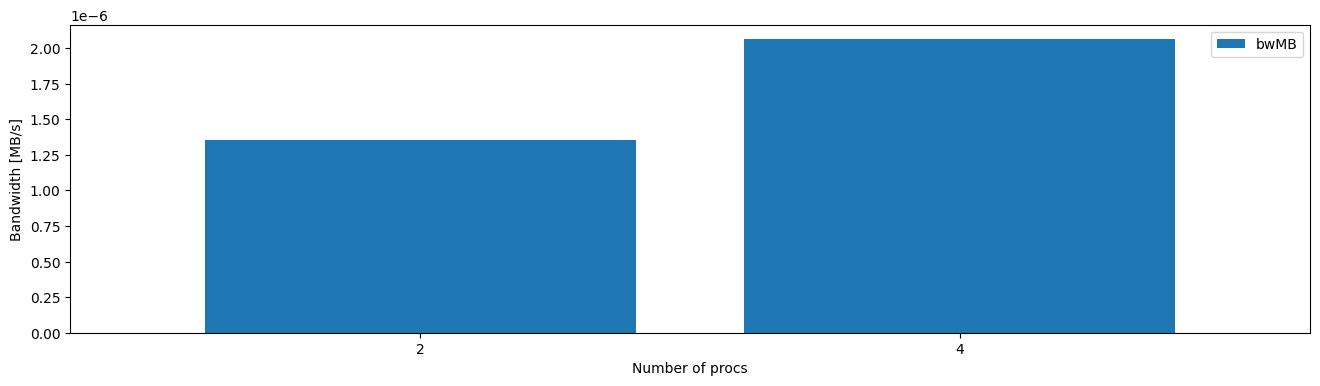

ranks,bwMB
i32,f64
2,0.000015
4,0.000015


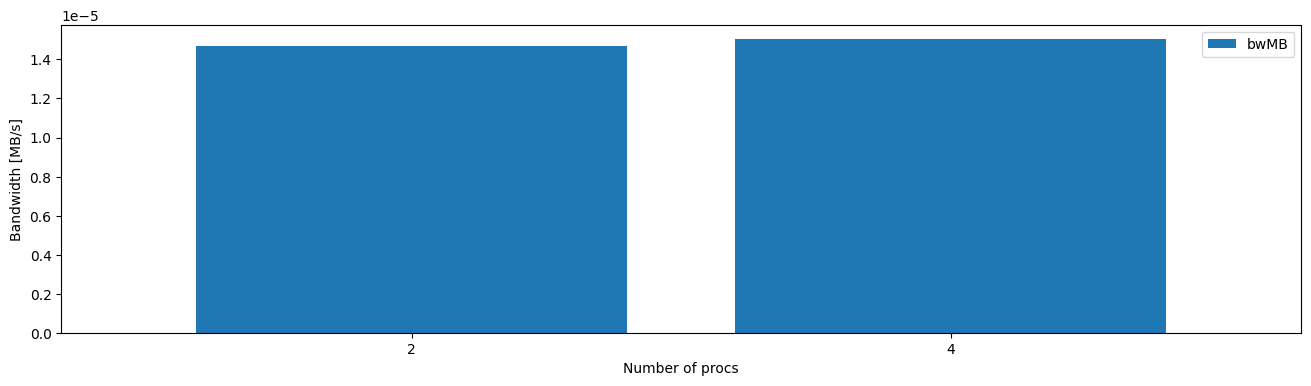

In [47]:
for ops in ["write", "read"]:
    fig = plt.figure(figsize=(16, 4), dpi=100)
    fig.patch.set_alpha(1)
    (
        df_plot
        .filter(pl.col("operation") == ops)
        .select("ranks", "bwMB")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("ranks")
        .plot(
            ax=fig.add_subplot(),
            kind="bar",
            xlabel="Number of procs",
            ylabel="Bandwidth [MB/s]",
            legend=True,
            rot=0,
            width=0.8,
        )
        
    )
    plt.show()